> Extracting images from video
done


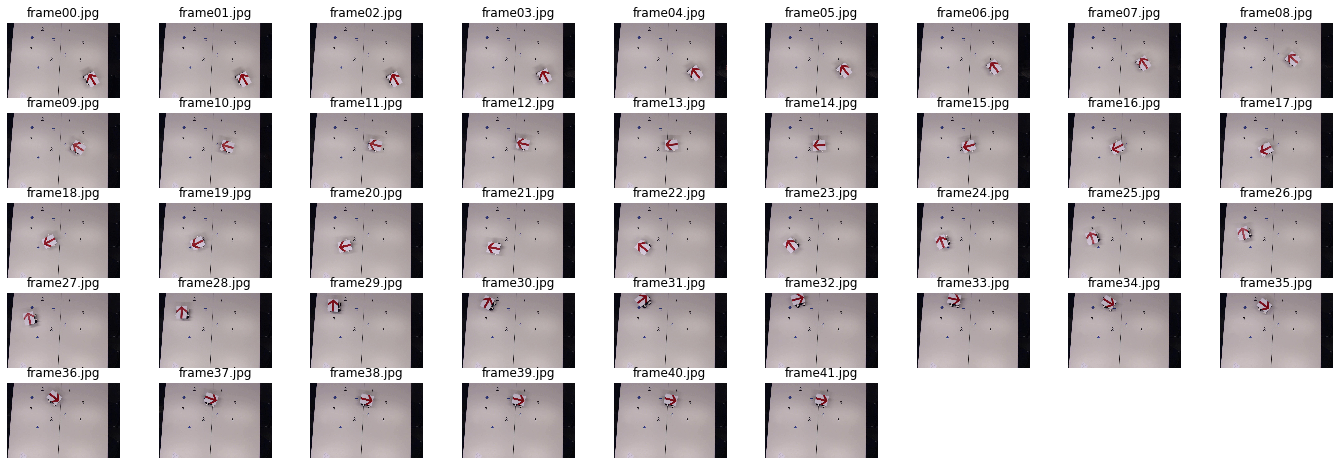

In [1]:
%matplotlib inline
from helpers import extract_images, load_data
import matplotlib.pyplot as plt
import numpy as np

# extract images from video
extract_images(data_path='./data/robot_parcours_1.avi')

# load data from extracted images
images, images_names = load_data()

# plot images
fig, axes = plt.subplots(5, int(len(images)/5)+1, figsize=(24, 8))
for ax, im, nm in zip(axes.ravel(), images, images_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)   
for ax in axes.ravel()[len(images):]:
    fig.delaxes(ax)

In [2]:
print(images[0].shape)

(480, 720, 3)


<b>###############################################################################################################################################################################################################</b> <br>
RED color detection

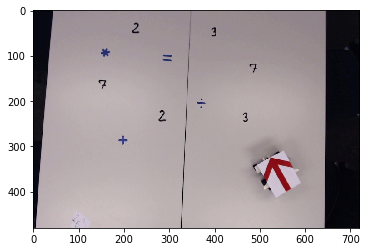

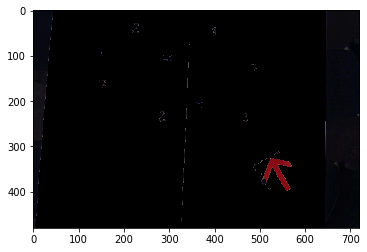

In [3]:
test_im = images[0] 
mask_red = test_im[:,:,2] > 90
test_mask = np.copy(test_im)
test_mask[mask_red] = 0


plt.figure()
plt.imshow(test_im)
plt.figure()
plt.imshow(test_mask)

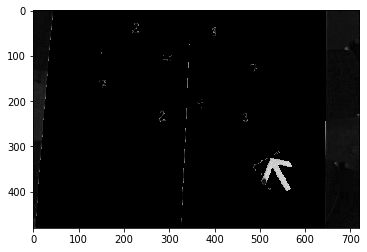

In [4]:
import skimage
plt.figure()
img = skimage.color.rgb2gray(test_mask[:,:,0])
plt.imshow(img, cmap='gray')

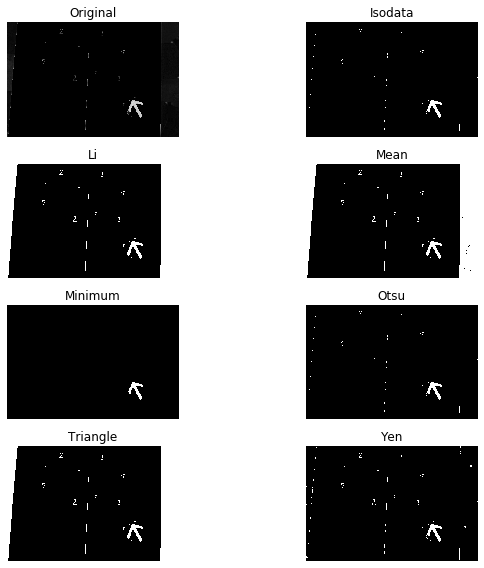

In [5]:
from skimage.filters import try_all_threshold
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

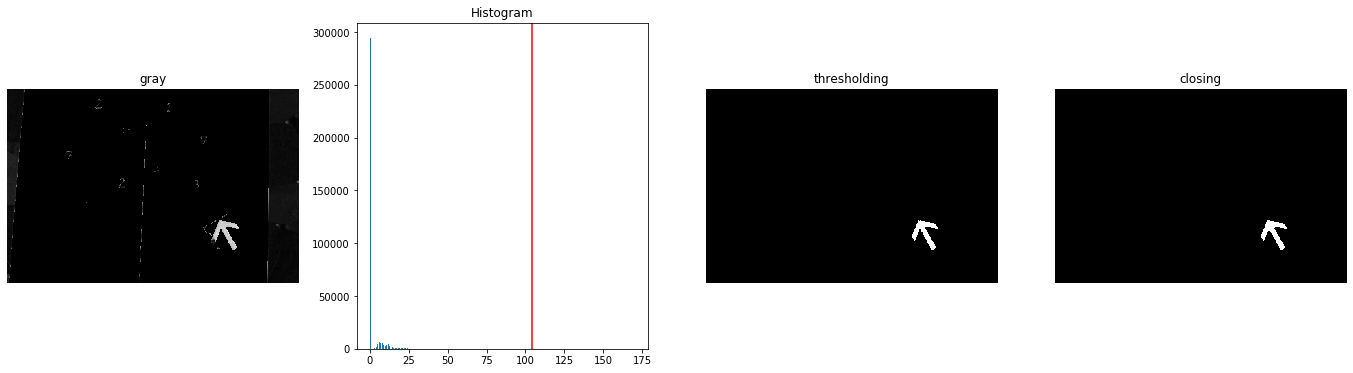

In [6]:
from skimage.filters import threshold_minimum
from skimage import morphology

fig, axes = plt.subplots(ncols=4, figsize=(24, 6))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('gray')
ax[0].axis('off')

threshold = threshold_minimum(img)

ax[1].hist(img.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(threshold, color='r')

binary = img > threshold

ax[2].imshow(binary, cmap='gray')
ax[2].set_title('thresholding')
ax[2].axis('off')

close = morphology.binary_closing(binary, skimage.morphology.selem.disk(3))

ax[3].imshow(close, cmap='gray')
ax[3].set_title('closing')
ax[3].axis('off')

plt.show

In [7]:
def biggest_label(properties):
    # assigns to max_lab the biggest labeled object on the image
    max_lab = properties[0]
    for lab in properties:
        if lab.area > max_lab.area:
            max_lab = lab
    return max_lab

In [8]:
def get_arrow_bb(img):
    mask_red = img[:,:,2] > 90
    test_mask = np.copy(img)
    test_mask[mask_red] = 0
    
    gray = skimage.color.rgb2gray(test_mask[:,:,0])
    
    threshold = threshold_minimum(gray)
    binary = gray > threshold
    close = morphology.binary_closing(binary, skimage.morphology.selem.disk(3))
    
    labels = label(close)
    biggest_lab = biggest_label(regionprops(labels))
    
    return biggest_lab.bbox

In [9]:
from skimage.measure import label, regionprops
import matplotlib.patches as mpatches

minr, minc, maxr, maxc = get_arrow_bb(test_im)
x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
#rad = max(maxc - minc, maxr - minr)/2
rad = biggest_lab.equivalent_diameter
circle = mpatches.Circle((x, y), rad, fill=False, edgecolor='g', linewidth=0.9)
circle_2 = mpatches.Circle((x, y), 7, color='r')
ax.add_patch(circle)
ax.add_patch(circle_2)

NameError: name 'biggest_lab' is not defined

(480, 720, 3)
325


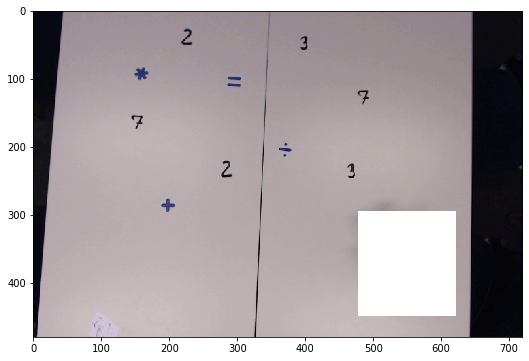

In [10]:
print(test_im.shape)
print(minr)
test_im[minr-30:maxr+50, minc-30:maxc+50] = 255
plt.figure(figsize=(10,6))
plt.imshow(test_im)

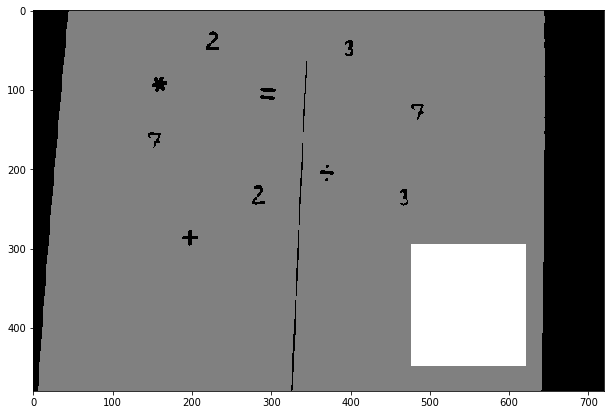

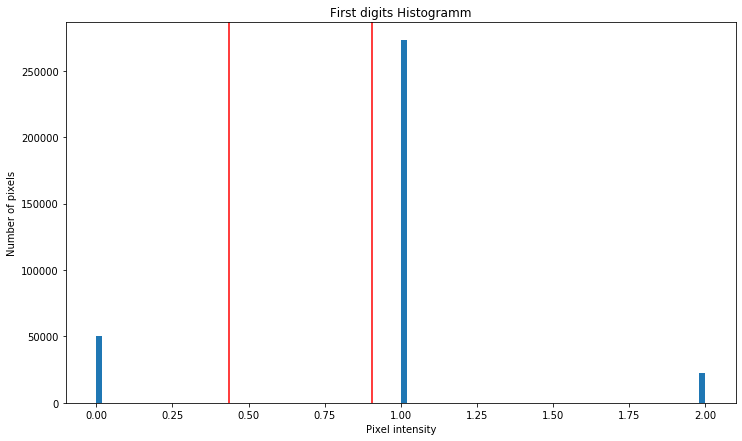

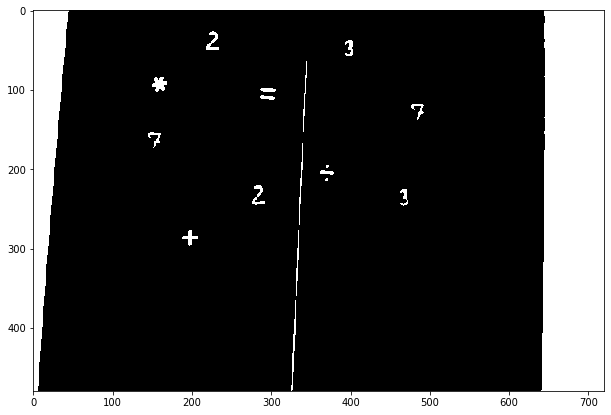

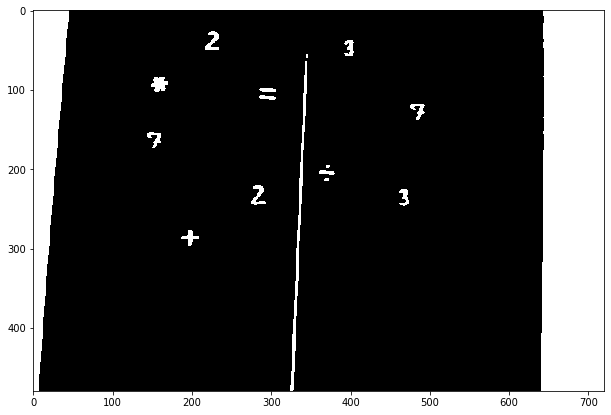

In [11]:
import skimage
from skimage import exposure
from skimage.filters import threshold_multiotsu
from skimage import morphology
from skimage.color import rgb2gray
# convert to grayscale 

gray = rgb2gray(test_im)

## Contrast stretching
a, b = np.percentile(gray, (1, 70))
img_rescale = exposure.rescale_intensity(gray, in_range=(a, b))

thresholds = threshold_multiotsu(img_rescale)

# Using the threshold values, we generate the three regions.
regions = np.digitize(gray, bins=thresholds)

plt.figure(figsize=(12,7))
plt.imshow(regions,cmap='gray')


# Display histogram
plt.figure(figsize=(12, 7))
plt.hist(regions.ravel(), bins=100)
plt.axvline(thresholds[1], color='r')
plt.axvline(thresholds[0], color='r')
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('First digits Histogramm')


binarized = regions == 0

plt.figure(figsize=(12,7))
plt.imshow(binarized,cmap='gray')

close = morphology.binary_dilation(binarized, skimage.morphology.selem.rectangle(1, 3))
#close = morphology.binary_erosion(close, skimage.morphology.selem.disk(1))
#close = morphology.binary_dilation(close, skimage.morphology.selem.disk(1))

plt.figure(figsize=(12,7))
plt.imshow(close,cmap='gray')

<b>###############################################################################################################################################################################################################</b> <br>
Same code for all image + make video

In [20]:
test_images = images.copy()

positions = []

for ind, im in enumerate(images): 

    fig, ax = plt.subplots()
    
    ax.imshow(im)
    ax.axis('off') 
    
    # draw rectangle around segmented coins
    minr, minc, maxr, maxc = get_arrow_bb(im)
    x, y = minc+(maxc-minc)/2, minr+(maxr-minr)/2
    rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    
    if len(positions) > 1:
        for last, pos in zip(positions,positions[1:]):
            point = mpatches.Circle(pos, 2, color='r')
            con = mpatches.ConnectionPatch(last,pos, 'data', color='k', linewidth=0.5)
            ax.add_patch(point)
            ax.add_patch(con)
    
    if ind > 0:
        positions.append((x,y))

    if ind < 10:
        plt.savefig('./tmp/red_arrow_0'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    else: 
        plt.savefig('./tmp/red_arrow_'+str(ind)+'.jpg', bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close()

In [21]:
import cv2
import numpy as np
import os

def frames_to_video(inputpath, outputpath, fps):
    image_array = []
    files = [nm for nm in os.listdir(inputpath) if '.jpg' in nm]  # make sure to only load .jpg
    files.sort()
    for i in range(len(files)):
        img = cv2.imread(inputpath + files[i])
        size =  (img.shape[1],img.shape[0])
        img = cv2.resize(img,size)
        image_array.append(img)
    fourcc = cv2.VideoWriter_fourcc('D', 'I', 'V', 'X')
    out = cv2.VideoWriter(outputpath,fourcc, fps, size)
    for i in range(len(image_array)):
        out.write(image_array[i])
    out.release()


inputpath = './tmp/'
outpath =  './tmp/video.mp4'
fps = 4
frames_to_video(inputpath,outpath,fps)